In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder
import category_encoders as ce

from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample
plt.style.use('ggplot')

In [2]:
!pip install xlsxwriter
!pip install imbalanced-learn


In [3]:
file_path = 'diabetes_prediction_dataset.csv'
df = pd.read_csv(file_path)
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
# Create an empty DataFrame to store outliers
df_outliers_only = pd.DataFrame(columns=df.columns)

# Dictionary to store the percentage of outliers for each column
percent_outliers = {}

# Function to calculate the 3-standard deviation range
def three_sd_range(series):
    mean = series.mean()
    sd = series.std()
    low = mean - 3 * sd
    high = mean + 3 * sd
    
    return (low, high)

# Iterate through numerical columns without binary values
# columns - age, bmi, HbA1c_level, blood_glucose_level
for col_name in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    lower, upper = three_sd_range(df[col_name])
    outliers_mask = (df[col_name] < lower) | (df[col_name] > upper)

     # Calculate the percentage of outliers
    num_outliers = outliers_mask.sum()
    total_values = len(df[col_name])
    percent_outliers[col_name] = (num_outliers / total_values) * 100
    
    # Print information about outliers in each column
    print(f"{col_name} has outliers: {outliers_mask.any()}")
    
    # Collect outliers into the DataFrame
    df_outliers_only = pd.concat([df_outliers_only, df[outliers_mask]])

# Print percentage of outliers for each column
print("\nPercentage of Outliers for Each Column:")
for col, percentage in percent_outliers.items():
    print(f"{col}: {percentage}%")

# Display the DataFrame with outliers only
print("\nDataFrame with Outliers Only:")
df_outliers_only



age has outliers: False
bmi has outliers: True
HbA1c_level has outliers: True
blood_glucose_level has outliers: True

Percentage of Outliers for Each Column:
age: 0.0%
bmi: 1.294%
HbA1c_level: 1.315%
blood_glucose_level: 1.403%

DataFrame with Outliers Only:


/var/folders/gk/6phh6ct93ys3r2dnsbn8_s0w0000gn/T/ipykernel_44790/3946874425.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers_only = pd.concat([df_outliers_only, df[outliers_mask]])


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
11,Female,54.0,0,0,former,54.70,6.0,100,0
39,Female,34.0,0,0,never,56.43,6.2,200,0
59,Female,67.0,0,0,never,63.48,8.8,155,1
93,Male,38.0,0,0,never,55.61,6.5,130,0
98,Female,30.0,0,0,No Info,50.13,6.0,100,0
...,...,...,...,...,...,...,...,...,...
99763,Female,50.0,0,0,never,35.91,6.0,280,1
99826,Male,63.0,0,1,No Info,27.32,6.6,300,1
99867,Male,64.0,1,0,former,33.12,5.7,300,1
99938,Male,55.0,0,1,former,30.42,6.2,300,1


In [5]:
# Create an empty DataFrame to store records without outliers
df_copy = df.copy()
df_without_outliers = pd.DataFrame(columns=df.columns)

# Exclude outliers from the copied DataFrame
df_without_outliers = df_copy.loc[~df_copy.index.isin(df_outliers_only.index)]

df_without_outliers

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [6]:
# Check the data types

print(df_outliers_only.dtypes)
print(df_without_outliers.dtypes)

# Convert 'gender' and 'smoking_history' columns to categorical
df_outliers_only['hypertension'] = df_outliers_only['hypertension'].astype('int')
df_outliers_only['heart_disease'] = df_outliers_only['heart_disease'].astype('int')
df_outliers_only['blood_glucose_level'] = df_outliers_only['blood_glucose_level'].astype('int')
df_outliers_only['diabetes'] = df_outliers_only['diabetes'].astype('int')

print(df_outliers_only.dtypes)

gender                  object
age                    float64
hypertension            object
heart_disease           object
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level     object
diabetes                object
dtype: object
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


<h1>Smoking History and Gender Encoding for df_without_outliers<h1>

In [7]:
# Applying WOE encoding for smoking history
woe_encoder_smoking_history = ce.WOEEncoder(cols=['smoking_history'])

# Fit and transform the encoder on the data
encoded_smoking_history_df = pd.DataFrame()
encoded_smoking_history_df['smoking_history_encoded'] = woe_encoder_smoking_history.fit_transform(df_without_outliers['smoking_history'], df_without_outliers['diabetes'])

# Concatenate the encoded data with the original DataFrame
new_df_without_outliers = pd.concat([df_without_outliers, encoded_smoking_history_df], axis=1)

# Display the updated DataFrame
new_df_without_outliers.head()



,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_encoded
0,Female,80.0,0,1,never,25.19,6.6,140,0,0.131757
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,-0.797024
2,Male,28.0,0,0,never,27.32,5.7,158,0,0.131757
3,Female,36.0,0,0,current,23.45,5.0,155,0,0.165669
4,Male,76.0,1,1,current,20.14,4.8,155,0,0.165669


In [8]:
# #Applying WOE encoding for gender

# Initialize the WOEEncoder
woe_encoder = ce.WOEEncoder(cols=['gender'])

# Fit and transform the encoder on the data
encoded_gender_df = pd.DataFrame()
encoded_gender_df['gender_encoded'] = woe_encoder.fit_transform(df_without_outliers['gender'], df_without_outliers['diabetes'])


new_df_without_outliers = pd.concat([new_df_without_outliers, encoded_gender_df], axis=1)

new_df_without_outliers.head()



,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_encoded,gender_encoded
0,Female,80.0,0,1,never,25.19,6.6,140,0,0.131757,-0.128959
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,-0.797024,-0.128959
2,Male,28.0,0,0,never,27.32,5.7,158,0,0.131757,0.160772
3,Female,36.0,0,0,current,23.45,5.0,155,0,0.165669,-0.128959
4,Male,76.0,1,1,current,20.14,4.8,155,0,0.165669,0.160772


<h1>Smoking History and Gender Encoding for df_outliers_only<h1>

In [9]:
# Applying WOE encoding for smoking history
woe_encoder_smoking_history = ce.WOEEncoder(cols=['smoking_history'])

# Fit and transform the encoder on the data
encoded_smoking_history_df_1 = pd.DataFrame()
encoded_smoking_history_df_1['smoking_history_encoded'] = woe_encoder_smoking_history.fit_transform(df_outliers_only['smoking_history'], df_outliers_only['diabetes'])

# Concatenate the encoded data with the original DataFrame
new_df_outliers_only = pd.concat([df_outliers_only, encoded_smoking_history_df_1], axis=1)

# Display the updated DataFrame
new_df_outliers_only.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_encoded
11,Female,54.0,0,0,former,54.70,6.0,100,0,0.310171
39,Female,34.0,0,0,never,56.43,6.2,200,0,-0.052540
59,Female,67.0,0,0,never,63.48,8.8,155,1,-0.052540
93,Male,38.0,0,0,never,55.61,6.5,130,0,-0.052540
98,Female,30.0,0,0,No Info,50.13,6.0,100,0,-0.273853


In [10]:
# #Applying WOE encoding for gender

# Initialize the WOEEncoder
woe_encoder = ce.WOEEncoder(cols=['gender'])

# Fit and transform the encoder on the data
encoded_gender_df_1 = pd.DataFrame()
encoded_gender_df_1['gender_encoded'] = woe_encoder.fit_transform(df_outliers_only['gender'],df_outliers_only['diabetes'])


new_df_outliers_only = pd.concat([new_df_outliers_only, encoded_gender_df_1], axis=1)

new_df_outliers_only.head()



,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_encoded,gender_encoded
11,Female,54.0,0,0,former,54.70,6.0,100,0,0.310171,-0.310005
39,Female,34.0,0,0,never,56.43,6.2,200,0,-0.052540,-0.310005
59,Female,67.0,0,0,never,63.48,8.8,155,1,-0.052540,-0.310005
93,Male,38.0,0,0,never,55.61,6.5,130,0,-0.052540,0.561670
98,Female,30.0,0,0,No Info,50.13,6.0,100,0,-0.273853,-0.310005


<h1>SMOTE Oversampling</h1>


In [11]:
is_diabetic_1 = new_df_without_outliers["diabetes"].value_counts()
print("Yes: ",is_diabetic_1[1])
print("No: ",is_diabetic_1[0])

is_diabetic_2 = new_df_outliers_only["diabetes"].value_counts()
print("Yes: ",is_diabetic_2[1])
print("No: ",is_diabetic_2[0])


Yes:  5736
No:  90572
Yes:  3084
No:  928


In [12]:
# Create copies of new_df_without_outliers and new_df_outliers_only
new_df_without_outliers_copy = new_df_without_outliers.copy()
new_df_outliers_only_copy = new_df_outliers_only.copy()

In [13]:
# Drop categorical Gender and Smoking_history columns
columns_to_drop = ["gender", "smoking_history"]
new_df_without_outliers_copy = new_df_without_outliers_copy.drop(columns=columns_to_drop)
new_df_outliers_only_copy = new_df_outliers_only_copy.drop(columns=columns_to_drop)

<h1>SMOTE for New_Df_Without_Outliers_Copy</h1>

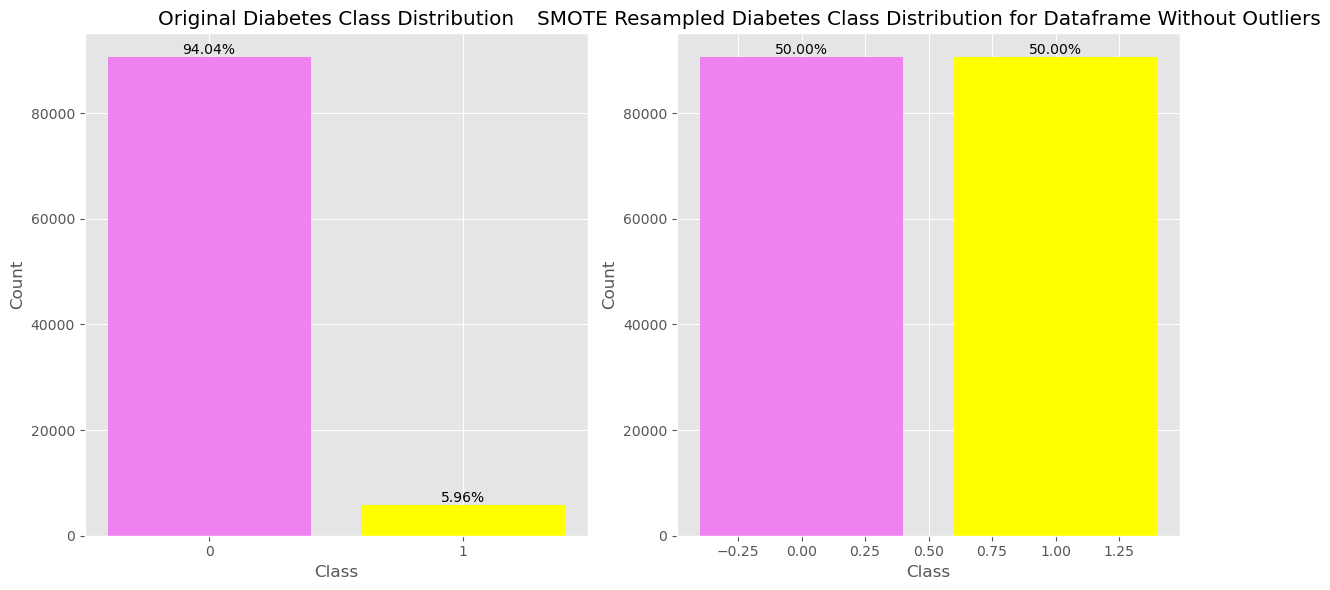

In [14]:
from imblearn.over_sampling import SMOTE

# Separate features (X) and target variable (y)
X = new_df_without_outliers_copy.drop("diabetes", axis=1)
y = new_df_without_outliers_copy["diabetes"]

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Count the occurrences of each class in the original dataset
original_class_counts = new_df_without_outliers_copy["diabetes"].value_counts()

# Calculate the percentage of each class
original_percentages = original_class_counts / len(new_df_without_outliers_copy) * 100

# Count the occurrences of each class in the resampled dataset
resampled_class_counts = pd.Series(y_resampled).value_counts()

# Calculate the percentage of each class
resampled_percentages = resampled_class_counts / len(y_resampled) * 100

# Plotting
plt.figure(figsize=(12, 6))

# Bar chart for original and SMOTE resampled class distribution
plt.subplot(1, 2, 1)
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['violet', 'yellow'])
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Diabetes Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['0', '1'])

plt.subplot(1, 2, 2)
bars_2 = plt.bar(resampled_class_counts.index, resampled_class_counts.values, color=['violet', 'yellow'])
for bar, label in zip(bars_2, resampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('SMOTE Resampled Diabetes Class Distribution for Dataframe Without Outliers')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()



In [15]:
# Create a DataFrame from the SMOTE resampled data
new_df_without_outliers_copy_smote_resampled = pd.DataFrame(data=X_resampled, columns=X.columns)
new_df_without_outliers_copy_smote_resampled["diabetes"] = y_resampled

new_df_without_outliers_copy_smote_resampled



,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_encoded,gender_encoded,diabetes
0,80.0,0,1,25.190000,6.600000,140,0.131757,-0.128959,0
1,54.0,0,0,27.320000,6.600000,80,-0.797024,-0.128959,0
2,28.0,0,0,27.320000,5.700000,158,0.131757,0.160772,0
3,36.0,0,0,23.450000,5.000000,155,0.165669,-0.128959,0
4,76.0,1,1,20.140000,4.800000,155,0.165669,0.160772,0
...,...,...,...,...,...,...,...,...,...
181139,80.0,0,0,27.191924,6.949298,126,0.554826,0.160772,1
181140,80.0,0,0,27.320000,5.800000,155,0.313504,-0.052799,1
181141,35.0,0,0,27.320357,6.995535,159,0.383605,0.160772,1
181142,58.0,0,0,27.320000,6.017092,155,-0.797024,0.160772,1


<h1>SMOTE for New_Df_Outliers_Only_Copy</h1> 

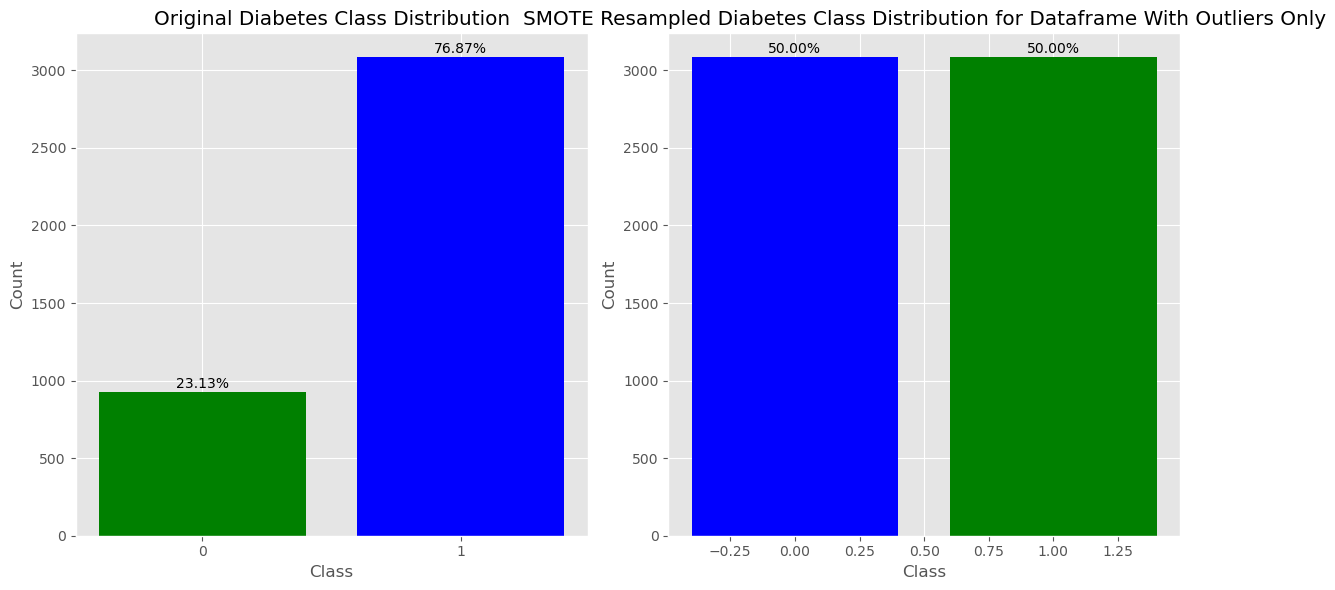

In [16]:
# Separate features (X1) and target variable (y1)
X1 = new_df_outliers_only_copy.drop("diabetes", axis=1)
y1 = new_df_outliers_only_copy["diabetes"]

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply1 SMOTE to the dataset
X1_resampled, y1_resampled = smote.fit_resample(X1, y1)

# Count the occurrences of each class in the original dataset
original_class_counts = new_df_outliers_only_copy["diabetes"].value_counts()

# Calculate the percentage of each class
original_percentages = original_class_counts / len(new_df_outliers_only_copy) * 100

# Count the occurrences of each class in the resampled dataset
resampled_class_counts = pd.Series(y1_resampled).value_counts()

# Calculate the percentage of each class
resampled_percentages = resampled_class_counts / len(y1_resampled) * 100

# Plotting
plt.figure(figsize=(12, 6))

# Bar chart for original and SMOTE resampled class distribution
plt.subplot(1, 2, 1)
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['blue', 'green'])
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Diabetes Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['1', '0'])

plt.subplot(1, 2, 2)
bars_2 = plt.bar(resampled_class_counts.index, resampled_class_counts.values, color=['blue', 'green'])
for bar, label in zip(bars_2, resampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('SMOTE Resampled Diabetes Class Distribution for Dataframe With Outliers Only')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()




In [17]:
# Create a DataFrame from the SMOTE resampled data
new_df_outliers_only_copy_smote_resampled = pd.DataFrame(data=X1_resampled, columns=X1.columns)
new_df_outliers_only_copy_smote_resampled["diabetes"] = y1_resampled

new_df_outliers_only_copy_smote_resampled

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_encoded,gender_encoded,diabetes
0,54.000000,0,0,54.700000,6.000000,100,0.310171,-0.310005,0
1,34.000000,0,0,56.430000,6.200000,200,-0.052540,-0.310005,0
2,67.000000,0,0,63.480000,8.800000,155,-0.052540,-0.310005,1
3,38.000000,0,0,55.610000,6.500000,130,-0.052540,0.561670,0
4,30.000000,0,0,50.130000,6.000000,100,-0.273853,-0.310005,0
...,...,...,...,...,...,...,...,...,...
6163,58.619390,0,0,48.248887,5.914183,158,-0.052540,-0.310005,0
6164,36.411190,0,0,47.570729,4.800000,127,-0.182851,-0.310005,0
6165,15.709946,0,0,50.525147,6.213743,82,-0.179245,-0.310005,0
6166,40.330285,0,0,51.053191,6.401829,155,-0.200757,-0.022104,0


<h1>Data Pre-Processing<h1>

<h1>Data Normalization for new_df_without_outliers_copy_smote_resampled<h1>

In [18]:
from sklearn.preprocessing import StandardScaler

# Specify the Excel file name to export data
excel_file_name = "new_df_without_outliers_copy_smote_resampled.xlsx"

# Create an Excel writer object
excel_writer = pd.ExcelWriter(excel_file_name, engine='xlsxwriter')


# Select numerical columns for standardization
numerical_columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history_encoded', 'gender_encoded']

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the selected numerical columns
new_df_without_outliers_copy_smote_resampled[numerical_columns] = scaler.fit_transform(new_df_without_outliers_copy_smote_resampled[numerical_columns])

# Print the standardized DataFrame
print(new_df_without_outliers_copy_smote_resampled)
        
# Write the standardized DataFrame to Excel file
new_df_without_outliers_copy_smote_resampled.to_excel(excel_writer, index=False)

# Save the Excel file
excel_writer.save()

             age  hypertension  heart_disease       bmi  HbA1c_level  \
0       1.349487             0              1 -0.580455     0.629254   
1       0.149555             0              0 -0.241118     0.629254   
2      -1.050378             0              0 -0.241118    -0.272186   
3      -0.681168             0              0 -0.857661    -0.973306   
4       1.164882             1              1 -1.384988    -1.173626   
...          ...           ...            ...       ...          ...   
181139  1.349487             0              0 -0.261522     0.979111   
181140  1.349487             0              0 -0.241118    -0.172026   
181141 -0.727319             0              0 -0.241061     1.025421   
181142  0.334160             0              0 -0.241118     0.045413   
181143  1.349487             1              0 -0.164762     0.192378   

        blood_glucose_level  smoking_history_encoded  gender_encoded  diabetes  
0                 -0.317312                 0.263730  

AttributeError: 'XlsxWriter' object has no attribute 'save'

<h1>Data Normalization for new_df_outliers_only_copy_smote_resampled<h1>

In [ ]:
# Specify the Excel file name to export data
excel_file_name = "new_df_outliers_only_copy_smote_resampled.xlsx"

# Create an Excel writer object
excel_writer = pd.ExcelWriter(excel_file_name, engine='xlsxwriter')



# Fit and transform the selected numerical columns
new_df_outliers_only_copy_smote_resampled[numerical_columns] = scaler.fit_transform(new_df_outliers_only_copy_smote_resampled[numerical_columns])

# Print the standardized DataFrame
print(new_df_outliers_only_copy_smote_resampled)

# Write the standardized DataFrame to Excel file
new_df_outliers_only_copy_smote_resampled.to_excel(excel_writer, index=False)

# Save the Excel file
excel_writer.close()

           age  hypertension  heart_disease       bmi  HbA1c_level  \
0     0.174516             0              0  0.930849    -0.357602   
1    -1.018012             0              0  1.073804    -0.233789   
2     0.949660             0              0  1.656370     1.375782   
3    -0.779506             0              0  1.006045    -0.048069   
4    -1.256518             0              0  0.553214    -0.357602   
...        ...           ...            ...       ...          ...   
6163  0.449954             0              0  0.397771    -0.410728   
6164 -0.874241             0              0  0.341732    -1.100480   
6165 -2.108582             0              0  0.585866    -0.225281   
6166 -0.640560             0              0  0.629500    -0.108843   
6167  0.591901             0              0  1.627652    -1.001929   

      blood_glucose_level  smoking_history_encoded  gender_encoded  diabetes  
0               -1.154539                 1.806645       -0.777719         0  
1